In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import expm, logm
from scipy.stats import norm
import statsmodels.api as sm
%matplotlib inline

In [2]:
%%capture
from tqdm.notebook import trange, tqdm
tqdm().pandas()

## Loading income data
**Dataset**: rfamxxxx.csv

**Years**: 1998 to 2012 (only even years)

**Variables**:
- *ANNO*: Year
- *NQUEST*: Household ID
- *Y1*: Net disposable income (w/o financial assets)
- *Y2*: Net disposable income

**Note**: data contain a currency shift from thousands of Italian Lire (until 2000) to Euro (from 2002) (1 Euro = 1936.27 Italian Lire).

In [3]:
years = [1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012]
rfam = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/rfam{year}.csv')
    # convert the Italian Lire to Euro for years 1998 and 2000
    if year in [1998, 2000]:
        df['Y2'] = df['Y2']*1000/1936.27
        df['Y1'] = df['Y1']*1000/1936.27
    # rename income to Y_xxxx
    #df.rename(columns={'Y2':f'Y'}, inplace=True)
    # fix the lower-case header for 2008 and 2012
    if year in [2008, 2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # filter only columns of interest
    df = df[['ANNO','NQUEST','Y1','Y2']]
    rfam.append(df)
rfam = pd.concat(rfam)

1998 2000 2002 2004 2006 2008 2010 2012 

In [4]:
rfam

,ANNO,NQUEST,Y1,Y2
0,1998,34,80050.819359,79761.603495
1,1998,123,6197.482789,1323.722054
2,1998,173,20761.567343,21034.256586
3,1998,304,12911.422477,13820.386620
4,1998,325,15803.581112,16236.758806
...,...,...,...,...
8146,2012,889749,21778.000000,21956.020998
8147,2012,889750,14800.000000,14925.801505
8148,2012,889751,26000.000000,26178.020998
8149,2012,889752,23100.000000,23131.980055


In [5]:
rfam[['Y1','Y2']].describe()

,Y1,Y2
count,6.301800e+04,6.301800e+04
mean,2.974698e+04,3.018494e+04
std,2.340649e+04,2.426811e+04
min,-4.338238e+04,-4.157511e+04
25%,1.598792e+04,1.601016e+04
50%,2.460000e+04,2.482162e+04
75%,3.760000e+04,3.801351e+04
max,1.024568e+06,1.022617e+06


In [6]:
rfam[(rfam['Y1']<0)|(rfam['Y2']<0)]

,ANNO,NQUEST,Y1,Y2
50,1998,4370,-43382.379524,-39084.425209
513,1998,29421,-13796.115387,-13796.115387
1007,1998,34224,-68.370257,352.868994
4099,1998,505327,-39297.205452,-39669.054419
4279,1998,505782,-8890.723463,-6432.737098
4657,1998,506714,-19701.663105,-18672.880962
700,2000,33781,1394.433628,-201.521482
4002,2000,611518,1859.244837,-693.085159
897,2004,91043,-5705.949686,-5693.503837
1313,2004,506132,-6400.000000,-6214.114000


In [7]:
# remove households with negative Y2
neg_nquest = rfam[(rfam['Y2']<0)]['NQUEST']
rfam = rfam[~rfam['NQUEST'].isin(neg_nquest)]
rfam

,ANNO,NQUEST,Y1,Y2
0,1998,34,80050.819359,79761.603495
1,1998,123,6197.482789,1323.722054
2,1998,173,20761.567343,21034.256586
3,1998,304,12911.422477,13820.386620
4,1998,325,15803.581112,16236.758806
...,...,...,...,...
8146,2012,889749,21778.000000,21956.020998
8147,2012,889750,14800.000000,14925.801505
8148,2012,889751,26000.000000,26178.020998
8149,2012,889752,23100.000000,23131.980055


## Load info dataset

**Dataset**: compxxxx.csv

**Variables**:
- *ANNO*: year
- *NQUEST*: Household ID
- *NCOMP*: Number of household members
- *AREA3*: 1=North, 2=Centre, 3=South and Islands
- *SESSO*: Sex
- *ETA*: Age(years)
- *ETA5*: Age groups:
    - 1 = up to 30 years
    - 2 = from 31 to 40 years
    - 3 = from 41 to 50 years
    - 4 = from 51 to 65 years
    - 5 = more than 65 years
- *STUDIO*: Educational qualification: 
    - 1 = none
    - 2 = elementary school
    - 3 = middle school
    - 4 = high school
    - 5 = bachelor’s degree
    - 6 = post-graduate qualification.

In [8]:
cols = ['ANNO','NQUEST','NCOMP','AREA3']
comp = []
for year in years:
    print(year, end=' ')
    df = pd.read_csv(f'data.nosync/comp{year}.csv')
    # fix the lower-case header for 2012
    if year in [2012]:
        df.rename(columns={'nquest':'NQUEST'}, inplace=True)
    # create the dataset with the value counts of the Age group
    A5 = df.groupby('NQUEST')['ETA5'].value_counts().to_frame().rename(columns={'ETA5':'COUNT'}).reset_index()
    A5 = pd.pivot_table(A5, values='COUNT', index='NQUEST', columns='ETA5')
    A5.columns = ['A'+str(x+1) for x in range(5)]
    A5.reset_index(inplace=True)
    A5 = A5.fillna(0).astype(dtype='int')
    # filter only columns of interest and drop duplicates
    df = df[cols].drop_duplicates()
    if len(df)-len(A5):
        print('ERROR while merging A5 with df')
    # join df with A5
    df = pd.merge(df, A5, how='left', on='NQUEST')
    # join datasets
    comp.append(df)
comp = pd.concat(comp)

1998 2000 2002 2004 2006 2008 2010 2012 

In [9]:
comp

,ANNO,NQUEST,NCOMP,AREA3,A1,A2,A3,A4,A5
0,1998,34,4,1,2,0,0,2,0
1,1998,123,4,3,2,0,0,2,0
2,1998,173,4,3,2,0,2,0,0
3,1998,304,3,3,1,2,0,0,0
4,1998,325,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
8146,2012,889749,3,3,1,0,0,0,2
8147,2012,889750,1,1,1,0,0,0,0
8148,2012,889751,2,1,2,0,0,0,0
8149,2012,889752,4,3,2,0,0,2,0


## Load poverty lines

In [10]:
pov = pd.read_csv('data.nosync/poverty lines.csv')
# convert the Italian Lire to Euro for years before 2000
pov.loc[:,'1997':'2000'] = pov.loc[:,'1997':'2000']/1936.27
pov = pov.set_index('NCOMP').unstack().to_frame().reset_index()
pov.columns = ['ANNO','COMP','Yp']
pov['Yp'] = pov['Yp']*12
pov['ANNO'] = pov['ANNO'].astype(dtype='int')
# compute scale
pov['Yscale'] = (pov.set_index('ANNO')['Yp']/pov.groupby('ANNO')['Yp'].first()).reset_index(drop=True)
pov

,ANNO,COMP,Yp,Yscale
0,1997,1,5310.511447,1.000000
1,1997,2,8865.629277,1.669449
2,1997,3,11835.617967,2.228715
3,1997,4,14468.705294,2.724541
4,1997,5,16889.026840,3.180301
...,...,...,...,...
114,2013,3,15521.400000,2.216672
115,2013,4,19022.520000,2.716680
116,2013,5,22173.480000,3.166681
117,2013,6,25207.680000,3.600007


## Combine the datasets and compute poverty classes

In [11]:
df = pd.merge(rfam, comp, how='left', on=['ANNO','NQUEST'])
# adjust NCOMP to have max 7 categories by components to merge with poverty thresholds
df['COMP'] = df['NCOMP'].mask(df['NCOMP']>7,7)
# combine df with poverty thersholds
df = pd.merge(df, pov, how='left', on=['ANNO','COMP'])
# compute exterme poverty thershold as % of Yp
Yp_perc = .5
df['Yep'] = Yp_perc*df['Yp']
# compute the poverty classes
df['C'] = 2
df['C'] = df['C'].mask(df['Y2']<=df['Yp'], 1)
df['C'] = df['C'].mask(df['Y2']<=df['Yep'], 0)
# compute equivalent income and classes
df['Ye'] = df['Y2']/df['Yscale']
df['Ce'] = 2
df['Ce'] = df['Ce'].mask(df['Y2']<=df['Yp']/df['Yscale'], 1)
df['Ce'] = df['Ce'].mask(df['Y2']<=df['Yep']/df['Yscale'], 0)
df

,ANNO,NQUEST,Y1,Y2,NCOMP,AREA3,A1,A2,A3,A4,A5,COMP,Yp,Yscale,Yep,C,Ye,Ce
0,1998,34,80050.819359,79761.603495,4,1,2,0,0,2,0,4,14929.122488,2.724542,7464.561244,2,29275.234627,2
1,1998,123,6197.482789,1323.722054,4,3,2,0,0,2,0,4,14929.122488,2.724542,7464.561244,0,485.851237,0
2,1998,173,20761.567343,21034.256586,4,3,2,0,2,0,0,4,14929.122488,2.724542,7464.561244,2,7720.291090,2
3,1998,304,12911.422477,13820.386620,3,3,1,2,0,0,0,3,12212.238996,2.228715,6106.119498,2,6201.056479,2
4,1998,325,15803.581112,16236.758806,2,1,0,1,0,1,0,2,9147.744891,1.669449,4573.872445,2,9725.816787,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62965,2012,889749,21778.000000,21956.020998,3,3,1,0,0,0,2,3,15814.440000,2.216659,7907.220000,2,9905.008206,2
62966,2012,889750,14800.000000,14925.801505,1,1,1,0,0,0,0,1,7134.360000,1.000000,3567.180000,2,14925.801505,2
62967,2012,889751,26000.000000,26178.020998,2,1,2,0,0,0,0,2,11890.560000,1.666661,5945.280000,2,15706.865437,2
62968,2012,889752,23100.000000,23131.980055,4,3,2,0,0,2,0,4,19381.560000,2.716650,9690.780000,2,8514.891125,2


## Analysis of trajectories
### Filter the dataset to exclude single year income and gaps between years

In [12]:
# Create a table with all sequence (for filtering df)
Y = df.pivot_table(values='Y2', columns=['ANNO'], index=['NQUEST'])
Y

ANNO,1998,2000,2002,2004,2006,2008,2010,2012
NQUEST,,,,,,,,
34,79761.603495,79347.921519,103554.0,90875.08432,NaN,NaN,NaN,NaN
123,1323.722054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,21034.256586,24124.931201,29594.0,26500.00000,30112.431202,34207.00111,33267.445036,49737.361331
304,13820.386620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,16236.758806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
889749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21956.020998
889750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14925.801505
889751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26178.020998


In [13]:
# Check if any sequence contains missing value in the middle
Y[(df.groupby('NQUEST')['ANNO'].max()+2-df.groupby('NQUEST')['ANNO'].min())/2!=(np.logical_not(Y.isna())).sum(axis=1)]

ANNO,1998,2000,2002,2004,2006,2008,2010,2012
NQUEST,,,,,,,,


In [14]:
# Create the list of trajectories with more than one value
nquest_index_final = Y[np.logical_not(Y.isna()).sum(axis=1)>1].index
len(nquest_index_final)

10597

In [15]:
# filter the dataframe
df = df[df['NQUEST'].isin(nquest_index_final)]
len(df['NQUEST'].unique())

10597

In [16]:
# show the table of CAPs
C = df.pivot_table(values='C', columns=['ANNO'], index=['NQUEST'])
C

ANNO,1998,2000,2002,2004,2006,2008,2010,2012
NQUEST,,,,,,,,
34,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
173,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
375,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
465,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
474,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
869038,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
869040,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
869041,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0


## Descriptive statistics

### Income stats by components

In [17]:
df.groupby(['COMP'])['Y2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
COMP,,,,,,,,
1,8434.0,18620.45,18326.74,0.0,11000.00,15736.18,22258.26,810218.64
2,11651.0,29723.83,20964.45,0.0,17766.21,25188.64,36028.54,473503.69
3,8353.0,37085.93,24924.16,0.0,22212.66,32802.76,45443.80,453843.73
4,7822.0,37992.71,26722.86,0.0,22124.30,33459.83,47565.52,1022616.85
5,2255.0,35153.54,22837.50,0.0,19605.10,30692.00,45252.09,205888.93
6,533.0,37926.16,23582.21,0.0,21100.00,33691.49,50428.15,144298.06
7,133.0,41892.25,33147.66,0.0,19850.00,34550.00,55200.00,242979.50


### Income stats by components and year

In [18]:
df.groupby(['COMP','ANNO'])['Y2'].describe().round(2)

count      mean       std       min       25%       50%       75%  \
COMP ANNO                                                                       
1    1998   534.0  14712.74  11112.20      0.00   8011.37  11724.35  18007.43   
     2000   806.0  15449.27  11996.01      0.00   8685.51  13128.59  19279.66   
     2002   931.0  15488.09  10688.91      0.00   9235.03  13225.45  19140.95   
     2004  1075.0  18325.71  25722.33      0.00  10426.59  15091.27  20647.63   
     2006  1177.0  19714.29  29898.59      0.00  11580.00  16337.81  22114.07   
     2008  1340.0  19901.40  12988.56      0.00  12320.50  17135.45  24194.59   
     2010  1414.0  20686.96  14909.08      0.00  12803.14  17866.91  24624.67   
     2012  1157.0  20305.68  13291.48      0.55  12635.60  17519.09  24100.00   
2    1998   985.0  23511.59  17161.01      0.00  13564.22  19301.03  27601.98   
     2000  1327.0  24802.01  16160.84      0.00  14460.79  21200.56  29881.70   
     2002  1305.0  26844.61  21015.70      0.00  15842.40  22918.10  32228.48   
     2004  1478.0  28797.18  21713.66    500.00  17384.63  24230.65  34034.88   
     2006  1579.0  29977.21  21088.94      0.00  18793.62  25878.20  36144.64   
     2008  1737.0  32209.24  21087.97      0.00  19826.11  28025.27  38750.56   
     2010  1774.0  33521.07  21701.40      0.00  20366.52  29083.80  40611.14   
     2012  1466.0  34037.42  22733.37      0.00  20419.37  29476.69  40587.25   
3    1998   911.0  29007.33  19858.12      0.00  17389.78  25380.83  35595.43   
     2000  1079.0  32570.59  21319.71      0.00  19618.67  29231.46  40421.35   
     2002  1038.0  35629.77  25774.45    200.00  21991.80  31227.21  43460.61   
     2004  1067.0  36115.07  21542.38    264.00  22771.75  32580.45  44064.82   
     2006  1085.0  38947.01  25436.36      0.00  24245.63  34528.05  47917.00   
     2008  1119.0  41142.52  27780.11   1200.00  25201.51  36126.11  48896.88   
     2010  1134.0  40737.69  24911.07      0.00  24617.41  36499.27  50553.61   
     2012   920.0  41519.98  28541.60    637.98  23321.74  35753.59  51059.01   
4    1998  1015.0  31517.63  20524.67      0.00  18631.34  27995.80  39005.63   
     2000  1205.0  33761.13  21069.88      0.00  19876.88  29840.88  41845.40   
     2002  1028.0  36227.53  23365.47      0.00  21714.40  32013.55  44996.70   
     2004   958.0  40205.38  41471.04      0.00  22494.32  34432.45  48224.70   
     2006   919.0  40327.94  26761.29    130.00  23704.25  35622.81  49515.09   
     2008   953.0  41645.50  24731.82      0.00  24687.02  37598.45  52065.34   
     2010   967.0  41903.36  24345.70      0.00  25365.21  38031.66  53260.66   
     2012   777.0  40511.81  25257.57      0.00  23400.00  36823.52  51978.65   
5    1998   328.0  29163.84  19263.41      0.00  17433.00  26003.09  38165.33   
     2000   361.0  31212.45  19837.43      0.00  17294.84  28301.84  39481.76   
     2002   293.0  34716.32  23425.37      0.00  18462.88  31440.18  43890.41   
     2004   271.0  35901.14  20982.36   1000.00  20035.00  32541.61  46463.31   
     2006   258.0  38616.96  24600.18    551.22  20791.50  32670.26  50859.84   
     2008   257.0  38000.61  22852.35      0.00  21477.32  32824.13  50253.62   
     2010   263.0  38647.36  25731.68      0.00  22129.00  32961.78  48653.54   
     2012   224.0  38585.33  25248.36      0.00  21100.00  32506.92  49576.32   
6    1998    69.0  33292.12  20706.55   4557.51  20290.97  30801.49  43594.13   
     2000    78.0  38055.49  25863.38      0.00  22146.69  32845.10  47842.53   
     2002    68.0  37709.26  18938.94      0.00  25495.72  35051.83  49988.03   
     2004    66.0  37977.34  19162.01   5000.00  21923.16  35568.37  53376.97   
     2006    62.0  43899.55  24271.79  10015.97  27870.79  38859.61  53076.31   
     2008    66.0  42508.61  30010.14      0.00  20414.39  36648.85  59731.56   
     2010    69.0  35275.28  22216.82      0.00  20806.33  31650.00  49841.09   
     2012    55.0  34856.15  24783.35      

### Income stats by poverty class

In [19]:
df.groupby(['C'])['Y2'].describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0,839.0,4396.181327,2926.331470,0.000000,2126.583202,4432.233108,6364.814824,1.350000e+04
1,3123.0,11879.771065,4532.983540,2790.161682,8306.666942,11724.695015,15012.156958,2.565000e+04
2,35219.0,33350.848879,24082.163622,5531.474944,19234.149414,28021.052961,41106.462111,1.022617e+06


### Income stats by poverty class and year

In [20]:
df.groupby(['C','ANNO'])['Y2'].describe()

count          mean           std          min           25%  \
C ANNO                                                                  
0 1998   144.0   3560.152952   2607.076640     0.000000   1367.484876   
  2000   139.0   4234.536187   2686.882405     0.000000   2074.865592   
  2002   100.0   3836.994161   2660.236191     0.000000   1800.000000   
  2004    73.0   4779.424591   2806.881619     0.000000   2880.000000   
  2006    74.0   4424.863273   2990.534962     0.000000   2463.235087   
  2008    75.0   5139.566834   3335.992633     0.000000   3000.000000   
  2010   120.0   4829.352993   3148.494670     0.000000   2793.414618   
  2012   114.0   4930.758007   3035.396181     0.000000   3000.000000   
1 1998   363.0   9815.947568   3527.080167  2790.161682   7169.422379   
  2000   459.0  10645.025322   4013.614836  3047.095705   7879.583877   
  2002   363.0  10584.165051   3905.562915  3000.000000   7800.000000   
  2004   423.0  12104.327150   4274.074841  3415.196366   8548.035090   
  2006   413.0  12661.101071   4677.469479  3600.000000   9500.494431   
  2008   397.0  13248.582767   4888.564035  3600.000000   9817.017000   
  2010   362.0  13066.563731   4628.021633  4003.166027  10000.000000   
  2012   343.0  13032.854160   4833.586806  3600.000000   9706.868067   
2 1998  3360.0  29170.371321  19001.559549  5531.474944  17281.680757   
  2000  4283.0  30566.090952  19668.554893  5858.170606  17934.294133   
  2002  4217.0  31523.971685  23037.052599  6000.000000  17923.200000   
  2004  4436.0  33115.205281  29243.196775  6650.000000  18832.391699   
  2006  4609.0  34240.142947  27167.497398  7004.611167  19920.927460   
  2008  5012.0  35074.018669  23614.952967  7200.000000  20224.405202   
  2010  5149.0  35585.711949  23028.922992  7150.000000  20737.896240   
  2012  4153.0  35874.370584  24155.758789  7154.284865  20395.190883   

                 50%           75%           max  
C ANNO                                            
0 1998   3715.256251   5378.898604  9.812681e+03  
  2000   4338.237952   6249.903164  1.032914e+04  
  2002   3776.324150   6000.000000  1.000000e+04  
  2004   4803.733755   6708.000000  1.084000e+04  
  2006   4694.392724   6005.436553  1.220000e+04  
  2008   5358.701700   7483.106858  1.328000e+04  
  2010   4804.749041   7064.247124  1.266000e+04  
  2012   5029.670166   6888.689370  1.350000e+04  
1 1998   9674.460070  12311.933497  2.051818e+04  
  2000  10484.075052  13540.208752  2.293562e+04  
  2002  10642.918542  13428.961051  2.134600e+04  
  2004  12600.000000  15014.935020  2.460000e+04  
  2006  12939.150371  16277.394850  2.538254e+04  
  2008  13434.806800  17069.613600  2.565000e+04  
  2010  13002.863849  16530.212946  2.438624e+04  
  2012  12950.000000  16608.025824  2.540899e+04  
2 1998  24648.376017  36094.364012  2.453274e+05  
  2000  25867.776705  37865.724695  3.253682e+05  
  2002  26521.200000  38528.000000  4.538437e+05  
  2004  27509.528914  40367.354953  1.022617e+06  
  2006  28861.472258  41911.270295  8.102186e+05  
  2008  29573.980462  43065.477464  3.951202e+05  
  2010  30127.647330  44063.508666  2.922587e+05  
  2012  30165.309793  44536.255998  3.138732e+05

### Percentage of households in each poverty classes

In [21]:
df.groupby(['C'])['Y2'].count()/len(df)

C
0    0.021413
1    0.079707
2    0.898880
Name: Y2, dtype: float64

### Percentage of households in each poverty classes by year

In [22]:
df.groupby(['ANNO','C'])['Y2'].count()/df.groupby(['ANNO'])['Y2'].count()

ANNO  C
1998  0    0.037238
      1    0.093871
      2    0.868891
2000  0    0.028478
      1    0.094038
      2    0.877484
2002  0    0.021368
      1    0.077564
      2    0.901068
2004  0    0.014801
      1    0.085766
      2    0.899432
2006  0    0.014521
      1    0.081044
      2    0.904435
2008  0    0.013676
      1    0.072392
      2    0.913931
2010  0    0.021311
      1    0.064287
      2    0.914402
2012  0    0.024729
      1    0.074403
      2    0.900868
Name: Y2, dtype: float64

### Total Number of household

In [23]:
len(df['NQUEST'].unique())

10597

## Function for indexes computation

In [24]:
# create multiindex for probability matrix
def P_index(m):
    tuples = []
    for i in range(m):
        for j in range(m):
            tuples.append((i,j))
    index = pd.MultiIndex.from_tuples(tuples, names=['i', 'j'])
    return index

# transition probability matrix
def get_P(df):
    prob = df.copy()
    prob.columns = ['NQUEST','i']
    prob['j'] = prob.groupby('NQUEST')['i'].shift(-1)
    prob = prob.dropna() # eliminate the last obs for each group
    prob['j'] = prob['j'].astype(dtype='int')
    prob = prob[['i','j']]
    prob['p_ij'] = 1
    prob = prob.groupby(['i','j']).count()
    prob['p_ij'] = prob.groupby(prob.index.get_level_values('i'))['p_ij'].transform(lambda x: x/x.sum())
    prob = prob.reindex(P_index(3), fill_value=0)
    P_hat = np.array(prob.iloc[:,0]).reshape(3, 3)
    return P_hat

# computation of the variance for Gini index
def integral_gini(df):
    year = df['ANNO'].iloc[0]
    kde = sm.nonparametric.KDEUnivariate(df['Y2'])
    kde.fit() # Estimate the densities
    #Y_ecdf = ECDF(df['Y2'])
    max_Y = int(df['Y2'].max())
    h = max_Y/1000
    range_ = [x*h for x in range(1000)]
    res = 0
    for dy in tqdm(range_, desc=f'integral {year}'):
        res_x = 0
        for dx in range_:
            res_x += np.abs(dy-dx)*kde.evaluate(dx)*h
        res += (res_x**2)*kde.evaluate(dy)*h
    return res

def integral_gini_df(df):
    kernel = pd.DataFrame(list(zip(kde.support,kde.density)), columns=['x','pdf'])
    kernel = kernel[kernel['x']>0]
    kernel['h'] = kernel['x'].diff()
    kernel.iloc[0,2] = kernel.iloc[0,0]
    kernel['integral1'] = kernel.apply(lambda a: (np.abs(kernel['x']-a['x'])*kernel['pdf']*kernel['h']).sum()**2, axis=1)
    return (kernel['integral1']*kernel['pdf']*kernel['h']).sum()

def integral_gini2(df, mu, P):
    year = df['ANNO'].iloc[0]
    
    P0 = P[:,0]
    P1 = P[:,1]
    mP0 = mu.T.dot(P0)[0]
    mP1 = mu.T.dot(P1)[0]

    kde0 = sm.nonparametric.KDEUnivariate(df[df['C']==0]['Y2'])
    kde0.fit() # Estimate the densities
    kde1 = sm.nonparametric.KDEUnivariate(df[df['C']==1]['Y2'])
    kde1.fit() # Estimate the densities
    max_Y = int(df['Y2'].max())
    h = max_Y/1000
    range_ = [x*h for x in range(1000)]
    res = 0
    for dy in tqdm(range_, desc=f'integral {year}'):
        res_x = 0
        for dx in range_:
            res_x += np.abs(dy-dx)*(mP0*kde0.evaluate(dx)+mP1*kde1.evaluate(dx))*h
        res += (res_x**2)*(mP0*kde0.evaluate(dy)+mP1*kde1.evaluate(dy))*h
    return res[0]

def integral_gini_df2(df, mu, P):
    P0 = P[:,0]
    P1 = P[:,1]
    mP0 = mu.T.dot(P0)[0]
    mP1 = mu.T.dot(P1)[0]

    kde0 = sm.nonparametric.KDEUnivariate(df[df['C']==0]['Y2'])
    kde0.fit() # Estimate the densities
    kde1 = sm.nonparametric.KDEUnivariate(df[df['C']==1]['Y2'])
    kde1.fit() # Estimate the densities
    kernel0 = pd.DataFrame(list(zip(kde0.support,kde0.density)), columns=['x0','pdf0'])
    kernel1 = pd.DataFrame(list(zip(kde1.support,kde1.density)), columns=['x1','pdf1'])
    kernel0 = kernel0[kernel0['x0']>0]
    kernel0['h0'] = kernel0['x0'].diff()
    kernel0.iloc[0,2] = kernel0.iloc[0,0]
    kernel0['integral0'] = kernel0.apply(lambda a: (np.abs(kernel0['x0']-a['x0'])*mP0*kernel0['pdf0']*kernel0['h0']).sum(), axis=1)
    kernel1 = kernel1[kernel1['x1']>0]
    kernel1['h1'] = kernel1['x1'].diff()
    kernel1.iloc[0,2] = kernel1.iloc[0,0]
    kernel1['integral1'] = kernel1.apply(lambda a: (np.abs(kernel1['x1']-a['x1'])*mP1*kernel1['pdf1']*kernel1['h1']).sum(), axis=1)
    kernel = pd.concat([kernel0.reset_index(drop=True), kernel1.reset_index(drop=True)], axis=1)
    kernel['x0'] = kernel['x0'].ffill()
    kernel['pdf0'] = kernel['pdf0'].fillna(0)
    kernel['h0'] = kernel['h0'].fillna(0)
    kernel['integral0'] = kernel['integral0'].fillna(0)
    kernel['integral'] = (kernel['integral0']+kernel['integral1'])**2
    return (kernel['integral']*mP0*kernel['pdf0']*kernel['h0']+kernel['integral']*mP1*kernel['pdf1']*kernel['h1']).sum()

def integral_gini_disc(df):
    freq, values = np.histogram(df['Y2'], bins=100)
    prob = list(freq/np.sum(freq))
    midvalues = [.5*(x+values[i+1]) for i, x in enumerate(values[:-1])]
    resy = 0
    for iy, dy in enumerate(midvalues):
        resx = 0
        for ix, dx in enumerate(midvalues):
            resx += np.abs(dy-dx)*prob[ix]
        resy += resx**2*prob[iy]
    return resy

# computation of the poverty indexes and their variances
def poverty_indexes(P, mu, y, y_p, res_integral=0):
    y1, y2 = y[0], y[1]
    yep, yp = y_p[0], y_p[1]
    P1 = P[:,0]
    P2 = P[:,1]
    mP1 = mu.T.dot(P1)[0]
    mP2 = mu.T.dot(P2)[0]
    # Headcount ratio
    Ht = mP1+mP2
    varH = Ht*(1-Ht)
    # Income gap
    It = 1-((y1*mP1+y2*mP2)/(yp*Ht))
    sigma2_I = y1**2*mP1+y2**2*mP2-(y1*mP1+y2*mP2)**2
    varI = sigma2_I/(yp*Ht)**2
    # Gini
    Gt = (y2-y1)*mP1*mP2/(Ht*(y1*mP1+y2*mP2))
    Theta = 2*(y2-y1)*mP1*mP2
    sigma2G = res_integral-(Theta**2)
    A2 = sigma2G*(Ht**2)/(16*(y1*mP1+y2*mP2)**2)
    varG = A2/Ht
    # Sen
    St = Ht*(It+(1-It)*Gt)
    varS = (1-Ht)*St**2/Ht
    return [Ht, It, Gt, St], [varH, varI, varG, varS]

# computation of confidence intervals
def conf_intervals(indexes, var, N, alpha=0.05):
    z = norm.ppf(1-alpha/2)
    # headcount ratio
    H = indexes[0]
    var_H = var[0]
    ci_H = [H+sign*z*np.sqrt(var_H/N) for sign in [-1,1]]
    # Income gap
    I = indexes[1]
    var_I = var[1] 
    ci_I = [I+sign*z*np.sqrt(var_I/N) for sign in [-1,1]]
    # Gini
    G = indexes[2]
    var_G = var[2]
    ci_G = [G*H**2/2+sign*z*np.sqrt(var_G/N) for sign in [-1,1]]
    # Sen
    S = indexes[3]
    var_S = var[3] 
    ci_S = [S+sign*z*np.sqrt(var_S/N) for sign in [-1,1]]
    return [ci_H[0],ci_H[1],ci_I[0],ci_I[1],ci_G[0],ci_G[1],ci_S[0],ci_S[1]]

# computation of the asymptotic indexes
def poverty_indexes_inf(G, y, y_p):
    y1, y2 = y[0], y[1]
    yep, yp = y_p[0], y_p[1]
    Pinf = expm(10e9*G)
    pi1 = Pinf[0,0]
    pi2 = Pinf[0,1]
    Hinf = pi1+pi2
    Iinf = (yp-y1)/yp*pi1/Hinf+(yp-y2)/yp*pi2/Hinf
    Ginf = ((y2-y1)*pi1*pi2)/(Hinf*(y1*pi1+y2*pi2))
    Sinf = Hinf*(Iinf+(1-Iinf)*Ginf)
    return [Hinf, Iinf, Ginf, Sinf]

## Poverty indexes (entire dataset)

In [25]:
P_hat = get_P(df[['NQUEST','C']])
print('Transition probability matrix')
print(P_hat)

G_hat = (logm(P_hat)/2) # equation (3.6)
print('Generator Matrix')
print(G_hat)

# estimate initial distribution using initial values of sequence
mu_first = np.array(df.groupby('NQUEST').first().groupby('C')['C'].count()/len(df.groupby('NQUEST').first())).reshape(3,1)
# estimate initial distribution using only 1998
mu_1998 = np.array(df[df['ANNO']==1998].groupby('C')['C'].count()/len(df[df['ANNO']==1998])).reshape(3,1)
print('Initial distribution')
print(mu_1998)

# average income by class
y = df.groupby('C')['Y2'].mean().tolist()
print('Avergae income by class:', y)
# use the max threshold
yp = pov.groupby('ANNO')['Yp'].max().max()
print('Poverty threshold:', yp)
# use the max income in C1 and C2
# yp = df[df['C']<2]['Y2'].max()
hh = len(df['NQUEST'].unique())
print('N:', hh)

# computation of poverty indexes based on generator matrix G and initial ditribution mu
poverty = []
i = []
for t in range(1998,2014):
    P = expm((t-1997)*G_hat)
    sub_df = df[(df['C']<2)&(df['ANNO']==t)].copy()
    if not sub_df.empty:
        res_integral = integral_gini_disc(sub_df)
        # variable threshold, average income and N (comment out for fixed)
#         yp = pov[pov['ANNO']==t]['Yp'].max()
#         y = sub_df.groupby('C')['Y2'].mean().tolist()
#         hh = len(df[df['ANNO']==t]['NQUEST'].unique())
    I, var = poverty_indexes(P, mu_1998, y, [Yp_perc*yp, yp], res_integral)
    CI = conf_intervals(I, var, hh) # hh is the number of households
    poverty.append(I+CI)
    i.append(t)
poverty = pd.DataFrame(poverty, columns=['H','I','G','S','H_L','H_U','I_L','I_U','G_L','G_U','S_L','S_U'], index=i)
# observed indexes
poverty['H_obs'] = (df[df['C']<2].groupby(['ANNO'])['Y2'].count()/df.groupby(['ANNO'])['Y2'].count())
poverty['I_obs'] = 1-df[df['C']<2].groupby('ANNO')['Y2'].sum()/(yp*df[df['C']<2].groupby(['ANNO'])['Y2'].count())
poverty['G_obs'] = df[(df['C']<2)].groupby('ANNO').apply(lambda y: y['Y2'].apply(lambda x: np.sum(np.abs(x-y['Y2']))).sum())/(2*df[df['C']<2].groupby(['ANNO'])['Y2'].count()*df[df['C']<2].groupby('ANNO')['Y2'].sum())
poverty['S_obs'] = poverty['H_obs']*(poverty['I_obs']+(1-poverty['I_obs'])*poverty['G_obs'])
poverty

Transition probability matrix
[[0.37104825 0.36772047 0.26123128]
 [0.07364341 0.4379845  0.48837209]
 [0.00549472 0.0345271  0.95997818]]
Generator Matrix
[[-0.54397001  0.48390807  0.06006194]
 [ 0.09610838 -0.46851874  0.37241036]
 [ 0.00239499  0.02572348 -0.02811847]]
Initial distribution
[[0.03723817]
 [0.09387122]
 [0.86889061]]
Avergae income by class: [4396.181326609935, 11879.771065192524, 33350.84887924999]
Poverty threshold: 29117.64
N: 10597


,H,I,G,S,H_L,H_U,I_L,I_U,G_L,G_U,S_L,S_U,H_obs,I_obs,G_obs,S_obs
1998,0.119527,0.656559,0.140748,0.084254,0.113350,0.125703,0.637780,0.675338,-0.006097,0.008108,0.079900,0.088608,0.131109,0.723908,0.307555,0.106044
1999,0.110312,0.651430,0.131059,0.076900,0.104347,0.116277,0.631585,0.671274,-0.006487,0.008082,0.072742,0.081058,NaN,NaN,NaN,NaN
2000,0.103210,0.648207,0.124820,0.071434,0.097418,0.109003,0.627484,0.668931,-0.007298,0.008628,0.067425,0.075443,0.122516,0.685587,0.288223,0.095098
2001,0.097839,0.646115,0.120707,0.067394,0.092182,0.103495,0.624684,0.667546,-0.007553,0.008708,0.063498,0.071291,NaN,NaN,NaN,NaN
2002,0.093823,0.644714,0.117926,0.064420,0.088271,0.099374,0.622724,0.666704,-0.007696,0.008734,0.060608,0.068231,0.098932,0.686551,0.289027,0.076884
2003,0.090842,0.643749,0.115999,0.062233,0.085370,0.096313,0.621325,0.666173,-0.007848,0.008805,0.058485,0.065982,NaN,NaN,NaN,NaN
2004,0.088639,0.643071,0.114638,0.060628,0.083228,0.094051,0.620315,0.665827,-0.008405,0.009305,0.056927,0.064330,0.100568,0.621320,0.250903,0.072040
2005,0.087017,0.642586,0.113663,0.059451,0.081651,0.092384,0.619578,0.665594,-0.008495,0.009355,0.055785,0.063118,NaN,NaN,NaN,NaN
2006,0.085825,0.642236,0.112958,0.058588,0.080492,0.091158,0.619039,0.665433,-0.009513,0.010345,0.054948,0.062229,0.095565,0.608155,0.268439,0.068171
2007,0.084949,0.641982,0.112444,0.057956,0.079641,0.090258,0.618644,0.665320,-0.009567,0.010378,0.054334,0.061577,NaN,NaN,NaN,NaN


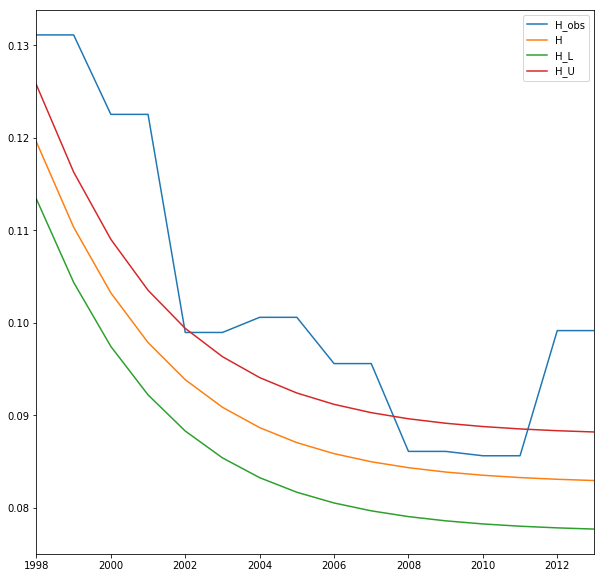

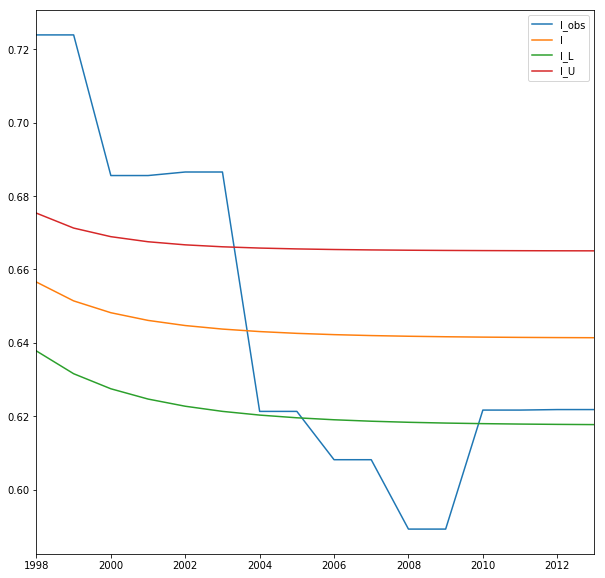

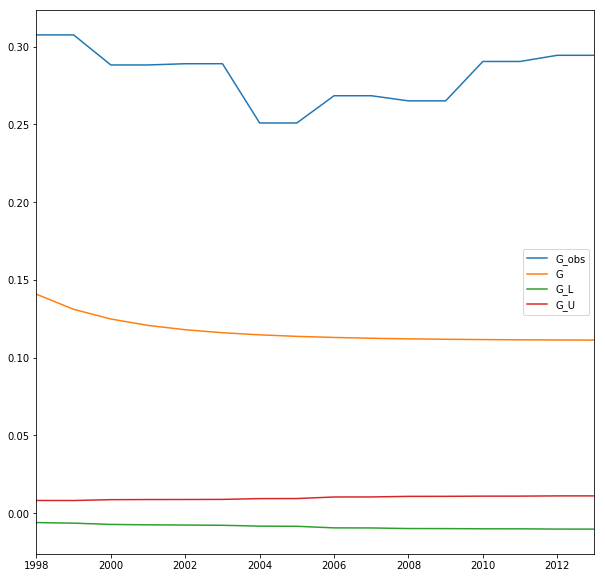

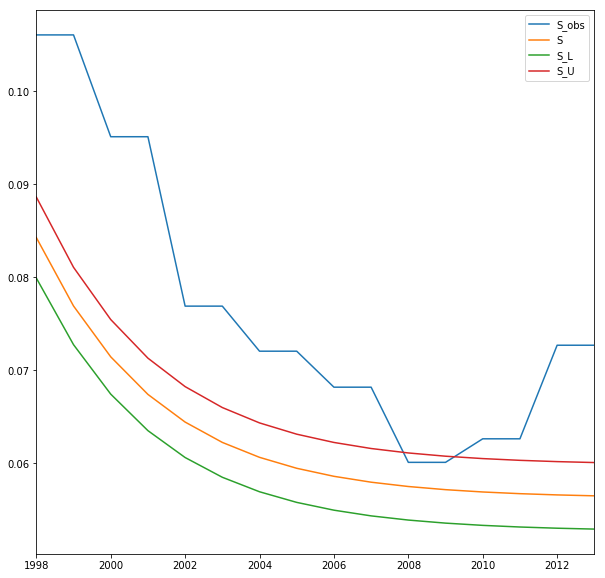

In [26]:
for i in ['H','I','G','S']:
    poverty[[i+'_obs',i,i+'_L',i+'_U']].ffill().plot(figsize=(10,10), )

## Poverty indexes (entire dataset - scaled income)

In [27]:
P_hat = get_P(df[['NQUEST','Ce']])
print('Transition probability matrix')
print(P_hat)

G_hat = (logm(P_hat)/2) # equation (3.6)
print('Generator Matrix')
print(G_hat)

# estimate initial distribution using initial values of sequence
mu_first = np.array(df.groupby('NQUEST').first().groupby('Ce')['Ce'].count()/len(df.groupby('NQUEST').first())).reshape(3,1)
# estimate initial distribution using only 1998
mu_1998 = np.array(df[df['ANNO']==1998].groupby('Ce')['Ce'].count()/len(df[df['ANNO']==1998])).reshape(3,1)
print('Initial distribution')
print(mu_1998)

y = df.groupby('Ce')['Ye'].mean().tolist()
print('Average income by class:', y)
# use the max threshold
yp = pov.groupby('ANNO')['Yp'].first().max()
print('Poverty threshold:', yp)
# use the max income in C1 and C2
# yp = df[df['Ce']<2]['Ye'].max()
hh = len(df['NQUEST'].unique())
print('N:', hh)

# computation of poverty indexes based on generator matrix G and initial ditribution mu
poverty = []
i = []
for t in range(1998,2014):
    P = expm((t-1997)*G_hat)
    sub_df = df[(df['Ce']<2)&(df['ANNO']==t)].copy()
    sud_df = sub_df.rename(columns={'Y2':'Y2old','Ye':'Y2'})
    if not sub_df.empty:
        res_integral = integral_gini_disc(sub_df)
        # variable threshold, average income and N (comment out for fixed)
#         yp = pov[pov['ANNO']==t].iloc[0,2]
#         y = sub_df.groupby('Ce')['Y2'].mean().tolist()
#         hh = len(df[df['ANNO']==t]['NQUEST'].unique())
    I, var = poverty_indexes(P, mu_1998, y, [Yp_perc*yp, yp], res_integral)
    CI = conf_intervals(I, var, hh) # hh is the number of households
    poverty.append(I+CI)
    i.append(t)
poverty = pd.DataFrame(poverty, columns=['H','I','G','S','H_L','H_U','I_L','I_U','G_L','G_U','S_L','S_U'], index=i)
# observed indexes
poverty['H_obs'] = (df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()/df.groupby(['ANNO'])['Ye'].count())
poverty['I_obs'] = 1-df[df['Ce']<2].groupby('ANNO')['Ye'].sum()/(yp*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count())
poverty['G_obs'] = df[(df['Ce']<2)].groupby('ANNO').apply(lambda h: h['Ye'].apply(lambda l: np.abs(l-h['Ye']).sum()).sum())/(2*df[df['Ce']<2].groupby(['ANNO'])['Ye'].count()*df[df['Ce']<2].groupby('ANNO')['Ye'].sum())
poverty['S_obs'] = poverty['H_obs']*(poverty['I_obs']+(1-poverty['I_obs'])*poverty['G_obs'])
poverty

Transition probability matrix
[[0.20434783 0.20869565 0.58695652]
 [0.0619469  0.31858407 0.61946903]
 [0.00352658 0.01183922 0.98463421]]
Generator Matrix
[[-0.8590864   0.43057601  0.42851039]
 [ 0.12761688 -0.62567902  0.49806213]
 [ 0.00264234  0.00945472 -0.01209705]]
Initial distribution
[[0.0165503 ]
 [0.02585984]
 [0.95758986]]
Average income by class: [792.9085970083804, 3951.8549992612784, 16881.113763113237]
Poverty threshold: 7279.4400000000005
N: 10597


,H,I,G,S,H_L,H_U,I_L,I_U,G_L,G_U,S_L,S_U,H_obs,I_obs,G_obs,S_obs
1998,0.035652,0.589638,0.224315,0.024303,0.032121,0.039182,0.544280,0.634997,-0.018001,0.018286,0.021897,0.026710,0.042410,0.698534,0.449457,0.035371
1999,0.031391,0.572706,0.198455,0.020639,0.028071,0.034711,0.523035,0.622377,-0.018472,0.018667,0.018457,0.022822,NaN,NaN,NaN,NaN
2000,0.028739,0.565233,0.186716,0.018577,0.025558,0.031920,0.512696,0.617770,-0.018041,0.018195,0.016521,0.020633,0.034624,0.639775,0.378118,0.026868
2001,0.027100,0.562022,0.181614,0.017387,0.024009,0.030192,0.507633,0.616410,-0.018454,0.018588,0.015403,0.019370,NaN,NaN,NaN,NaN
2002,0.026093,0.560651,0.179425,0.016686,0.023058,0.029128,0.505090,0.616211,-0.018773,0.018895,0.014745,0.018627,0.029487,0.617975,0.383060,0.022537
2003,0.025475,0.560055,0.178473,0.016268,0.022475,0.028475,0.503762,0.616348,-0.018977,0.019093,0.014352,0.018183,NaN,NaN,NaN,NaN
2004,0.025096,0.559787,0.178044,0.016016,0.022118,0.028075,0.503041,0.616534,-0.019620,0.019732,0.014115,0.017916,0.023925,0.511220,0.333095,0.016126
2005,0.024865,0.559660,0.177840,0.015863,0.021900,0.027830,0.502634,0.616687,-0.019707,0.019817,0.013972,0.017754,NaN,NaN,NaN,NaN
2006,0.024723,0.559596,0.177738,0.015770,0.021767,0.027680,0.502398,0.616795,-0.022182,0.022290,0.013884,0.017656,0.025903,0.467304,0.330341,0.016663
2007,0.024637,0.559563,0.177684,0.015714,0.021685,0.027588,0.502259,0.616866,-0.022219,0.022327,0.013831,0.017596,NaN,NaN,NaN,NaN


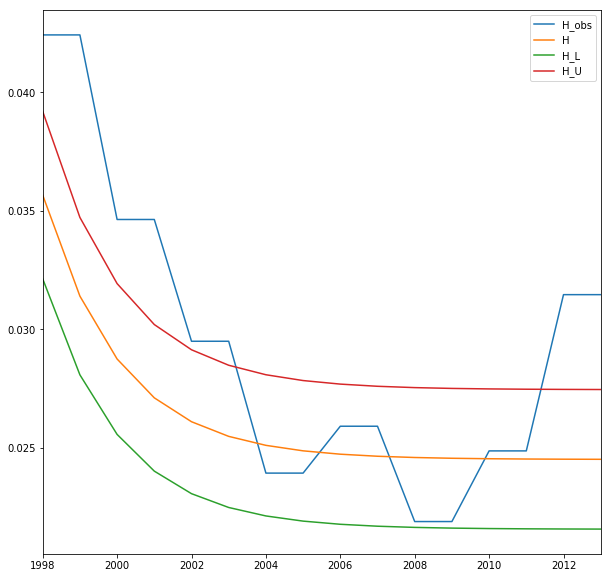

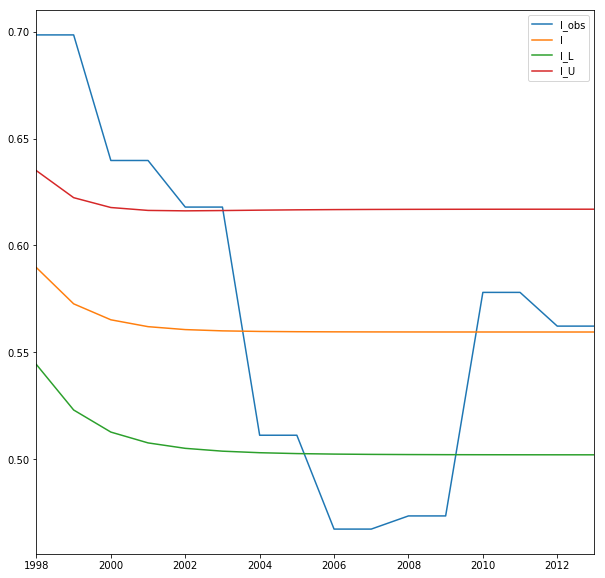

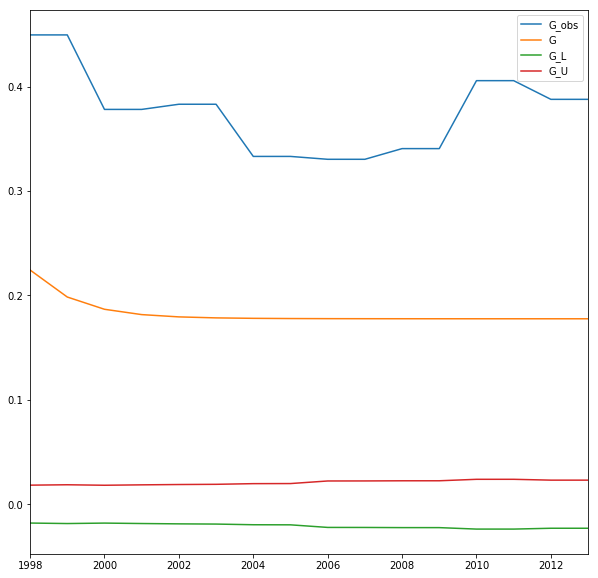

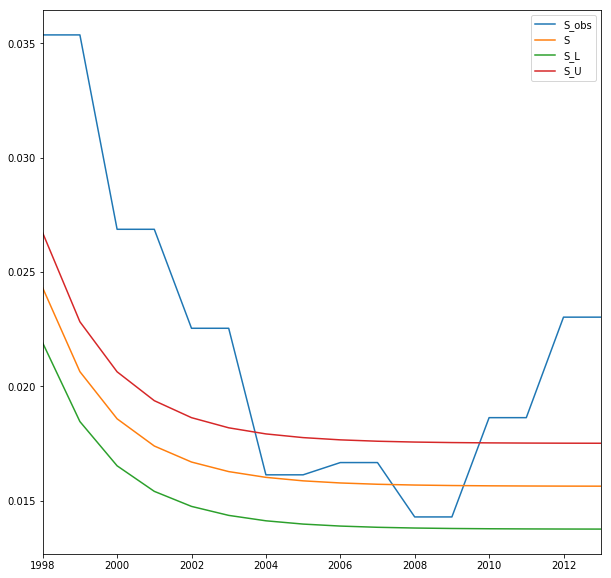

In [28]:
for i in ['H','I','G','S']:
    poverty[[i+'_obs',i,i+'_L',i+'_U']].ffill().plot(figsize=(10,10), )

## Poverty indexes (selected number of households components)

In [29]:
df.groupby(['ANNO','COMP'])['NQUEST'].count().unstack().append(df.groupby('COMP')['NQUEST'].nunique())

COMP,1,2,3,4,5,6,7
ANNO,,,,,,,
1998,534,985,911,1015,328,69,25
2000,806,1327,1079,1205,361,78,25
2002,931,1305,1038,1028,293,68,17
2004,1075,1478,1067,958,271,66,17
2006,1177,1579,1085,919,258,62,16
2008,1340,1737,1119,953,257,66,12
2010,1414,1774,1134,967,263,69,10
2012,1157,1466,920,777,224,55,11
NQUEST,2949,4184,3363,2837,923,253,66


In [30]:
components = 3

df_comp = df[df['COMP']==components].copy()

P_hat = get_P(df_comp[['NQUEST','C']])
print('Transition probability matrix')
print(P_hat)

G_hat = (logm(P_hat)/2) # equation (3.6)
print('Generator Matrix')
print(G_hat)

# estimate initial distribution using initial values of sequence
mu_first = np.array(df_comp.groupby('NQUEST').first().groupby('C')['C'].count()/len(df_comp.groupby('NQUEST').first())).reshape(3,1)
# estimate initial distribution using only 1998
mu_1998 = np.array(df_comp[df_comp['ANNO']==1998].groupby('C')['C'].count()/len(df_comp[df_comp['ANNO']==1998])).reshape(3,1)
print('Initial distribution')
print(mu_1998)

# average income by class
y = df_comp.groupby('C')['Y2'].mean().tolist()
print('Avergae income by class:', y)
# use the max threshold
yp = pov[pov['COMP']==components]['Yp'].max()
print('Poverty threshold:', yp)
# use the max income in C1 and C2
# yp = df[df['C']<2]['Y2'].max()
hh = len(df_comp['NQUEST'].unique())
print('N:', hh)

# computation of poverty indexes based on generator matrix G and initial ditribution mu
poverty = []
i = []
for t in range(1998,2014):
    P = expm((t-1997)*G_hat)
    sub_df = df_comp[(df_comp['C']<2)&(df_comp['ANNO']==t)].copy()
    if not sub_df.empty:
        res_integral = integral_gini_disc(sub_df)
        # variable threshold, average income and N (comment out for fixed)
#         yp = pov[(pov['ANNO']==t)&(pov['COMP']==components)].iloc[0,2]
#         y = sub_df.groupby('C')['Y2'].mean().tolist()
#         hh = len(df_comp[df_comp['ANNO']==t]['NQUEST'].unique())
    I, var = poverty_indexes(P, mu_1998, y, [Yp_perc*yp, yp], res_integral)
    CI = conf_intervals(I, var, hh) # hh is the number of households
    poverty.append(I+CI)
    i.append(t)
poverty = pd.DataFrame(poverty, columns=['H','I','G','S','H_L','H_U','I_L','I_U','G_L','G_U','S_L','S_U'], index=i)
# observed indexes
poverty['H_obs'] = (df_comp[df_comp['C']<2].groupby(['ANNO'])['Y2'].count()/df_comp.groupby(['ANNO'])['Y2'].count())
poverty['I_obs'] = 1-df_comp[df_comp['C']<2].groupby('ANNO')['Y2'].sum()/(yp*df_comp[df_comp['C']<2].groupby(['ANNO'])['Y2'].count())
poverty['G_obs'] = df_comp[(df_comp['C']<2)].groupby('ANNO').apply(lambda y: y['Y2'].apply(lambda x: np.sum(np.abs(x-y['Y2']))).sum())/(2*df_comp[df_comp['C']<2].groupby(['ANNO'])['Y2'].count()*df_comp[df_comp['C']<2].groupby('ANNO')['Y2'].sum())
poverty['S_obs'] = poverty['H_obs']*(poverty['I_obs']+(1-poverty['I_obs'])*poverty['G_obs'])
poverty

Transition probability matrix
[[0.33962264 0.38679245 0.27358491]
 [0.06515581 0.44192635 0.49291785]
 [0.00353123 0.02692562 0.96954315]]
Generator Matrix
[[-0.59010749  0.52900436  0.06110312]
 [ 0.08863726 -0.46002223  0.37138497]
 [ 0.00145934  0.01991465 -0.02137399]]
Initial distribution
[[0.03732162]
 [0.07354555]
 [0.88913282]]
Avergae income by class: [4425.790893378703, 11689.067067131447, 39840.91940043009]
Poverty threshold: 16136.04
N: 3363


,H,I,G,S,H_L,H_U,I_L,I_U,G_L,G_U,S_L,S_U,H_obs,I_obs,G_obs,S_obs
1998,0.100516,0.394887,0.144896,0.048505,0.090353,0.110678,0.330146,0.459628,-0.009963,0.011427,0.043601,0.053409,0.110867,0.545397,0.256048,0.073372
1999,0.091485,0.376984,0.126085,0.041675,0.081741,0.101229,0.307381,0.446586,-0.010360,0.011416,0.037236,0.046113,NaN,NaN,NaN,NaN
2000,0.084208,0.366663,0.114701,0.036993,0.074822,0.093594,0.292998,0.440327,-0.010945,0.011758,0.032870,0.041116,0.101946,0.482584,0.226778,0.061160
2001,0.078581,0.360513,0.107741,0.033743,0.069486,0.087675,0.283518,0.437508,-0.011306,0.011971,0.029838,0.037649,NaN,NaN,NaN,NaN
2002,0.074329,0.356720,0.103386,0.031458,0.065464,0.083195,0.277055,0.436386,-0.009957,0.010529,0.027706,0.035210,0.081888,0.405711,0.168489,0.041423
2003,0.071162,0.354297,0.100578,0.029834,0.062473,0.079851,0.272533,0.436062,-0.010175,0.010684,0.026191,0.033477,NaN,NaN,NaN,NaN
2004,0.068822,0.352695,0.098711,0.028671,0.060266,0.077378,0.269310,0.436081,-0.012105,0.012573,0.025106,0.032235,0.099344,0.346060,0.179071,0.046012
2005,0.067104,0.351605,0.097435,0.027833,0.058647,0.075560,0.266986,0.436224,-0.012256,0.012695,0.024326,0.031341,NaN,NaN,NaN,NaN
2006,0.065845,0.350845,0.096543,0.027228,0.057463,0.074227,0.265297,0.436393,-0.014447,0.014866,0.023762,0.030694,0.084793,0.345074,0.207513,0.040783
2007,0.064925,0.350307,0.095911,0.026790,0.056598,0.073253,0.264065,0.436548,-0.014546,0.014950,0.023353,0.030226,NaN,NaN,NaN,NaN


Components of household: 3


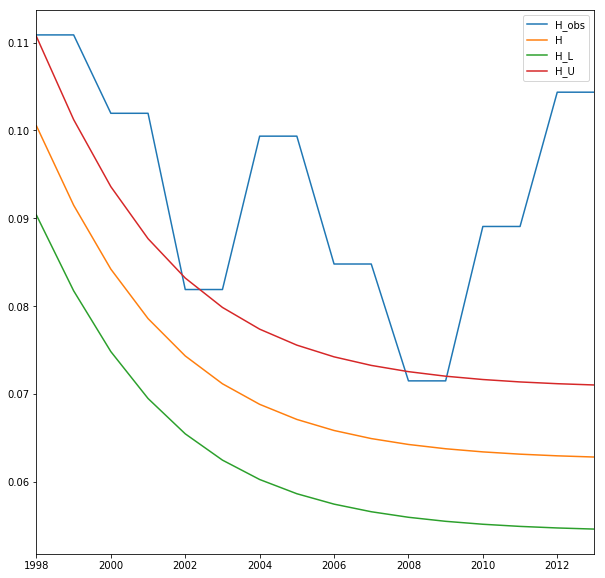

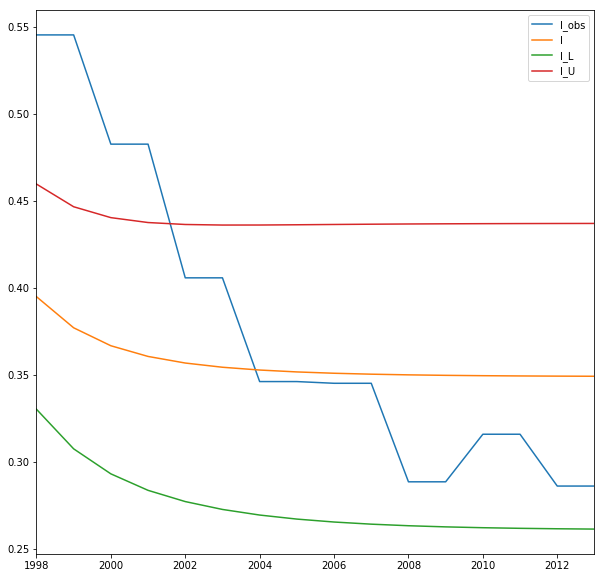

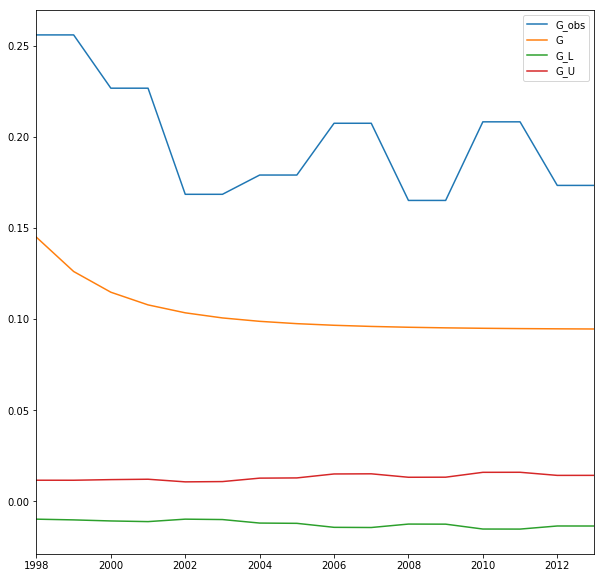

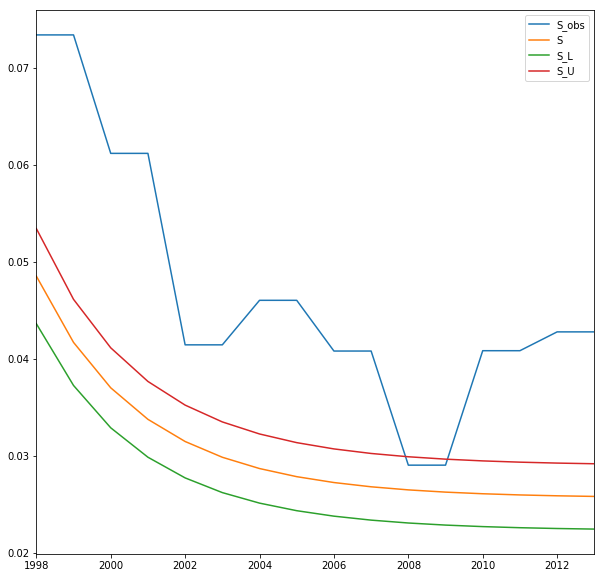

In [31]:
print('Components of household:', components)
for i in ['H','I','G','S']:
    poverty[[i+'_obs',i,i+'_L',i+'_U']].ffill().plot(figsize=(10,10), )